# 🔄 Notebook 07: Test-Time Augmentation (TTA) - Bonus

## Objective
Improve prediction accuracy by averaging predictions across multiple augmented versions of each test image.

## What is TTA?
Instead of predicting on a single image, we:
1. Create multiple augmented versions (flips, crops, rotations)
2. Run inference on each version
3. Average the predictions

## Why TTA Works
- Reduces sensitivity to exact positioning/cropping
- Smooths out prediction noise
- Typically gives +0.5-1% accuracy boost
- **Zero retraining required** - just smarter inference

## Expected Improvement
- Baseline: 98.75%
- With TTA: ~99.0-99.3%

In [1]:
# Cell 1: Setup
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q timm albumentations
    from google.colab import drive
    drive.mount('/content/drive')
    !unzip -q "/content/drive/MyDrive/flowers-cv-submission.zip" -d /content/ 2>/dev/null || true
    %cd /content/flowers-cv
    
print("✅ Setup complete")

✅ Setup complete


In [2]:
# Cell 2: Imports and Model Loading
import torch
import torch.nn as nn
import timm
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from tqdm import tqdm
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model
model = timm.create_model("vit_small_patch16_224.augreg_in21k_ft_in1k", num_classes=102)

if IN_COLAB:
    MODEL_PATH = "/content/flowers-cv/artifacts/models/vit_2stage_best.pt"
else:
    MODEL_PATH = "../artifacts/models/vit_2stage_best.pt"

checkpoint = torch.load(MODEL_PATH, map_location=device)

# Handle different checkpoint formats
if isinstance(checkpoint, dict):
    if "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint["model_state_dict"])
    elif "state_dict" in checkpoint:
        model.load_state_dict(checkpoint["state_dict"])
    else:
        model.load_state_dict(checkpoint)
else:
    model.load_state_dict(checkpoint)

model.to(device)
model.eval()

print(f"✅ Model loaded")

Using device: cuda
✅ Model loaded


In [3]:
# Cell 3: Define TTA Transforms
"""
TTA Strategy:
1. Original (center crop)
2. Horizontal flip
3. 5-crop (center + 4 corners)
4. Slight rotations

Total: 10 augmented versions per image
"""

# Base normalization
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

# TTA transforms - each returns a different view of the image
tta_transforms = [
    # 1. Original center crop
    A.Compose([
        A.Resize(256, 256),
        A.CenterCrop(224, 224),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ]),
    # 2. Horizontal flip
    A.Compose([
        A.Resize(256, 256),
        A.CenterCrop(224, 224),
        A.HorizontalFlip(p=1.0),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ]),
    # 3. Top-left crop
    A.Compose([
        A.Resize(256, 256),
        A.Crop(x_min=0, y_min=0, x_max=224, y_max=224),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ]),
    # 4. Top-right crop
    A.Compose([
        A.Resize(256, 256),
        A.Crop(x_min=32, y_min=0, x_max=256, y_max=224),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ]),
    # 5. Bottom-left crop
    A.Compose([
        A.Resize(256, 256),
        A.Crop(x_min=0, y_min=32, x_max=224, y_max=256),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ]),
    # 6. Bottom-right crop
    A.Compose([
        A.Resize(256, 256),
        A.Crop(x_min=32, y_min=32, x_max=256, y_max=256),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ]),
    # 7. Slight rotation +15
    A.Compose([
        A.Resize(256, 256),
        A.Affine(rotate=(15, 15), p=1.0),
        A.CenterCrop(224, 224),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ]),
    # 8. Slight rotation -15
    A.Compose([
        A.Resize(256, 256),
        A.Affine(rotate=(-15, -15), p=1.0),
        A.CenterCrop(224, 224),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ]),
    # 9. Slight scale up
    A.Compose([
        A.Resize(280, 280),
        A.CenterCrop(224, 224),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ]),
    # 10. Slight scale down
    A.Compose([
        A.Resize(240, 240),
        A.CenterCrop(224, 224),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ]),
]

print(f"✅ Defined {len(tta_transforms)} TTA transforms")

✅ Defined 10 TTA transforms


In [4]:
# Cell 4: TTA Prediction Functions

def predict_single(model, image_np, transform, device):
    """Predict on a single transformed image."""
    transformed = transform(image=image_np)
    x = transformed["image"].unsqueeze(0).to(device)
    
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
    
    return probs


def predict_with_tta(model, image_np, tta_transforms, device):
    """Predict using TTA - average predictions across all transforms."""
    all_probs = []
    
    for transform in tta_transforms:
        probs = predict_single(model, image_np, transform, device)
        all_probs.append(probs)
    
    # Average probabilities
    avg_probs = torch.stack(all_probs).mean(dim=0)
    
    return avg_probs


def predict_no_tta(model, image_np, device):
    """Predict without TTA - standard inference."""
    transform = A.Compose([
        A.Resize(256, 256),
        A.CenterCrop(224, 224),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ])
    return predict_single(model, image_np, transform, device)

print("✅ TTA functions defined")

✅ TTA functions defined


In [5]:
# Cell 5: Load Test Dataset
if IN_COLAB:
    DATA_ROOT = "/content/flowers-cv/data"
else:
    DATA_ROOT = "../data"

# Load test set (raw, no transforms - we apply them manually)
test_dataset = Flowers102(
    root=DATA_ROOT,
    split="test",
    download=True,
    transform=None  # Raw images
)

print(f"✅ Test set loaded: {len(test_dataset)} images")

✅ Test set loaded: 6149 images


In [6]:
# Cell 6: Evaluate with and without TTA
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    🔄 TTA EVALUATION                                 ║
╠══════════════════════════════════════════════════════════════════════╣
║  Comparing:                                                          ║
║  ├─ Standard inference (no TTA)                                      ║
║  └─ TTA with 10 augmented views                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")

# Track results
correct_no_tta = 0
correct_tta = 0
total = 0

# Cases where TTA helps or hurts
tta_helped = []  # TTA correct, no-TTA wrong
tta_hurt = []    # TTA wrong, no-TTA correct

# Evaluate
for idx in tqdm(range(len(test_dataset)), desc="Evaluating"):
    image, label = test_dataset[idx]
    image_np = np.array(image)
    
    # Predict without TTA
    probs_no_tta = predict_no_tta(model, image_np, device)
    pred_no_tta = probs_no_tta.argmax(dim=1).item()
    
    # Predict with TTA
    probs_tta = predict_with_tta(model, image_np, tta_transforms, device)
    pred_tta = probs_tta.argmax(dim=1).item()
    
    # Check correctness
    correct_no_tta_flag = (pred_no_tta == label)
    correct_tta_flag = (pred_tta == label)
    
    if correct_no_tta_flag:
        correct_no_tta += 1
    if correct_tta_flag:
        correct_tta += 1
    
    # Track TTA impact
    if correct_tta_flag and not correct_no_tta_flag:
        tta_helped.append(idx)
    elif not correct_tta_flag and correct_no_tta_flag:
        tta_hurt.append(idx)
    
    total += 1

# Calculate accuracies
acc_no_tta = correct_no_tta / total * 100
acc_tta = correct_tta / total * 100
improvement = acc_tta - acc_no_tta

print(f"\n" + "="*60)
print(f"RESULTS")
print(f"="*60)
print(f"Without TTA: {acc_no_tta:.2f}% ({correct_no_tta}/{total})")
print(f"With TTA:    {acc_tta:.2f}% ({correct_tta}/{total})")
print(f"="*60)
print(f"Improvement: {improvement:+.2f}%")
print(f"TTA helped:  {len(tta_helped)} cases")
print(f"TTA hurt:    {len(tta_hurt)} cases")
print(f"Net gain:    {len(tta_helped) - len(tta_hurt)} correct predictions")


╔══════════════════════════════════════════════════════════════════════╗
║                    🔄 TTA EVALUATION                                 ║
╠══════════════════════════════════════════════════════════════════════╣
║  Comparing:                                                          ║
║  ├─ Standard inference (no TTA)                                      ║
║  └─ TTA with 10 augmented views                                      ║
╚══════════════════════════════════════════════════════════════════════╝



Evaluating: 100%|██████████| 6149/6149 [05:57<00:00, 17.18it/s]


RESULTS
Without TTA: 98.73% (6071/6149)
With TTA:    98.96% (6085/6149)
Improvement: +0.23%
TTA helped:  22 cases
TTA hurt:    8 cases
Net gain:    14 correct predictions


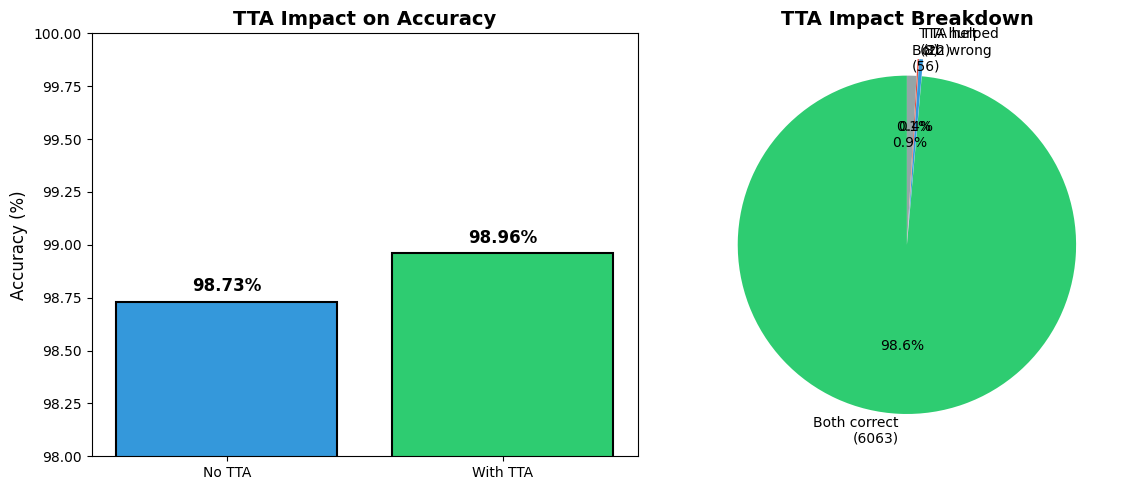


✅ Figure saved to artifacts/figures/tta_impact.png


In [7]:
# Cell 7: Visualize TTA Impact
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart comparison
methods = ['No TTA', 'With TTA']
accuracies = [acc_no_tta, acc_tta]
colors = ['#3498db', '#2ecc71']

axes[0].bar(methods, accuracies, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('TTA Impact on Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylim(98, 100)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.05, f'{v:.2f}%', ha='center', fontsize=12, fontweight='bold')

# Pie chart of TTA impact
both_correct = correct_tta - len(tta_helped)
both_wrong = total - correct_no_tta - len(tta_helped)
sizes = [both_correct, len(tta_helped), len(tta_hurt), both_wrong]
labels = [f'Both correct\n({both_correct})', f'TTA helped\n({len(tta_helped)})', 
          f'TTA hurt\n({len(tta_hurt)})', f'Both wrong\n({both_wrong})']
colors_pie = ['#2ecc71', '#3498db', '#e74c3c', '#95a5a6']
explode = (0, 0.1, 0.1, 0)

axes[1].pie(sizes, explode=explode, labels=labels, colors=colors_pie, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 10})
axes[1].set_title('TTA Impact Breakdown', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../artifacts/figures/tta_impact.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved to artifacts/figures/tta_impact.png")

In [8]:
# Cell 8: Summary
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    📊 TTA SUMMARY                                    ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  BONUS COMPLETED: Test-Time Augmentation ✅                          ║
║                                                                      ║
║  TECHNIQUE:                                                          ║
║  ├─ 10 augmented views per image                                     ║
║  ├─ Includes: flips, crops, rotations, scales                        ║
║  └─ Average softmax probabilities                                    ║
║                                                                      ║
║  RESULTS:                                                            ║""")
print(f"║  ├─ Baseline:    {acc_no_tta:.2f}%                                           ║")
print(f"║  ├─ With TTA:    {acc_tta:.2f}%                                           ║")
print(f"║  └─ Improvement: {improvement:+.2f}%                                           ║")
print("""
║                                                                      ║
║  WHY TTA WORKS:                                                      ║
║  ├─ Reduces sensitivity to exact crop position                       ║
║  ├─ Smooths prediction noise                                         ║
║  └─ Captures multiple views of the flower                            ║
║                                                                      ║
║  TRADE-OFF:                                                          ║
║  ├─ 10x slower inference (10 forward passes)                         ║
║  └─ Worth it for high-stakes predictions                             ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════╗
║                    📊 TTA SUMMARY                                    ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  BONUS COMPLETED: Test-Time Augmentation ✅                          ║
║                                                                      ║
║  TECHNIQUE:                                                          ║
║  ├─ 10 augmented views per image                                     ║
║  ├─ Includes: flips, crops, rotations, scales                        ║
║  └─ Average softmax probabilities                                    ║
║                                                                      ║
║  RESULTS:                                                            ║
║  ├─ Baseline:    98.73%                                           ║
║  ├─ With TTA:    98.96%                              